In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

category_costs_filtered = pd.read_pickle("category_costs_filtered.pkl")

In [5]:
orders_cleaned = pd.read_pickle("orders_cleaned.pkl")

C:\Users\Vaishnavi J\AppData\Local\Temp\ipykernel_27200\765999372.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_impact, x="abs_increase", y="product_category_name_english", palette="coolwarm")


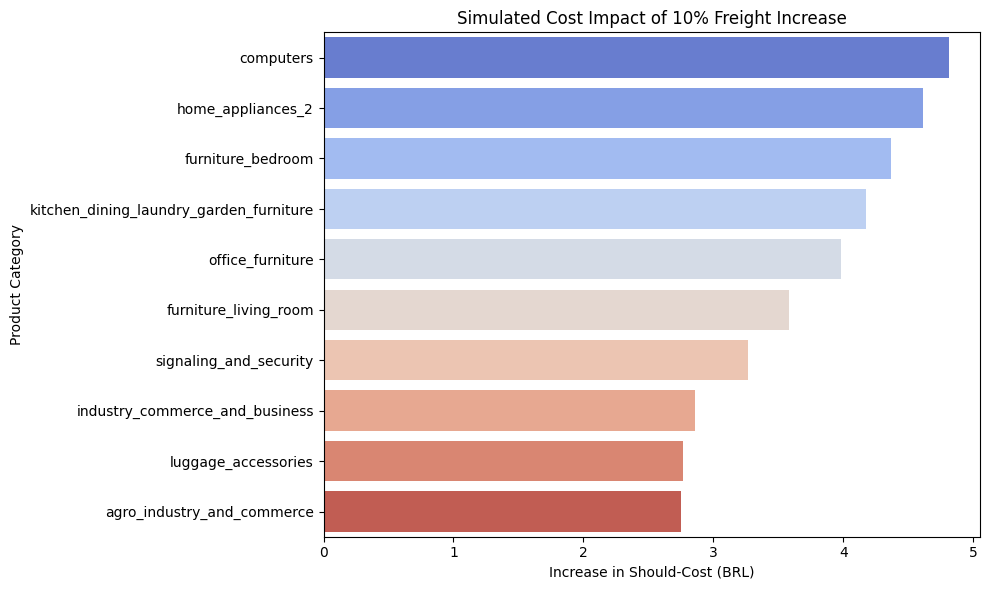

,product_category_name_english,avg_price,avg_freight,total_orders,should_cost,freight_10pct_increase,new_should_cost,abs_increase,pct_increase
0,computers,1104.32,48.11,216,1152.43,52.92,1157.24,4.81,0.42
1,home_appliances_2,451.73,46.10,261,497.83,50.71,502.44,4.61,0.93
2,furniture_bedroom,176.04,43.69,119,219.73,48.06,224.10,4.37,1.99
3,kitchen_dining_laundry_garden_furniture,163.93,41.78,291,205.72,45.96,209.89,4.18,2.03
4,office_furniture,159.31,39.83,1753,199.13,43.81,203.12,3.98,2.00
5,furniture_living_room,137.49,35.82,520,173.30,39.40,176.89,3.58,2.07
6,signaling_and_security,107.49,32.69,199,140.18,35.96,143.45,3.27,2.33
7,industry_commerce_and_business,145.09,28.56,268,173.65,31.41,176.50,2.86,1.64
8,luggage_accessories,127.78,27.69,1148,155.47,30.46,158.24,2.77,1.78
9,agro_industry_and_commerce,332.84,27.48,246,360.32,30.23,363.07,2.75,0.76


In [4]:
#Simulate a 10% increase in average freight costs
category_costs_simulated = category_costs_filtered.copy()
category_costs_simulated["freight_10pct_increase"] = category_costs_simulated["avg_freight"] * 1.10
category_costs_simulated["new_should_cost"] = category_costs_simulated["avg_price"] + category_costs_simulated["freight_10pct_increase"]

#Calculate the absolute and % change in cost
category_costs_simulated["abs_increase"] = category_costs_simulated["new_should_cost"] - category_costs_simulated["should_cost"]
category_costs_simulated["pct_increase"] = (category_costs_simulated["abs_increase"] / category_costs_simulated["should_cost"]) * 100

#Sort by highest impact
top_impact = category_costs_simulated.sort_values(by="abs_increase", ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_impact, x="abs_increase", y="product_category_name_english", palette="coolwarm")
plt.title("Simulated Cost Impact of 10% Freight Increase")
plt.xlabel("Increase in Should-Cost (BRL)")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

top_impact.round(2)

Promotion scenario

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Aggregate customer metrics
customer_summary = (
    orders_cleaned.groupby("customer_unique_id")
    .agg(
        total_spend=("payment_value", "sum"),
        avg_order_value=("payment_value", "mean"),
        num_orders=("order_id", "nunique"),
        avg_freight=("freight_value", "mean"),
        avg_delivery_time=("delivery_time_days", "mean")
    )
    .dropna()
)

#Normalize features for clustering
features = customer_summary[["total_spend", "avg_order_value", "num_orders", "avg_freight", "avg_delivery_time"]]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

#Fit KMeans model
kmeans = KMeans(n_clusters=3, random_state=42)
customer_summary["segment"] = kmeans.fit_predict(scaled_features)

#Simulate impact of a 5% and 10% discount on top 2 segments
impact_summary = customer_summary.groupby("segment").agg(
    num_customers=("total_spend", "count"),
    total_spend=("total_spend", "sum"),
    avg_order_value=("avg_order_value", "mean")
)

impact_summary["5pct_discount_revenue"] = impact_summary["total_spend"] * 0.95
impact_summary["10pct_discount_revenue"] = impact_summary["total_spend"] * 0.90

#Calculate revenue difference from current
impact_summary["revenue_loss_5pct"] = impact_summary["total_spend"] - impact_summary["5pct_discount_revenue"]
impact_summary["revenue_loss_10pct"] = impact_summary["total_spend"] - impact_summary["10pct_discount_revenue"]

impact_summary.round(2)

C:\Users\Vaishnavi J\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,num_customers,total_spend,avg_order_value,5pct_discount_revenue,10pct_discount_revenue,revenue_loss_5pct,revenue_loss_10pct
segment,,,,,,,
0,86196,13165103.47,126.02,12506848.30,11848593.12,658255.17,1316510.35
1,4374,5512556.58,795.34,5236928.75,4961300.92,275627.83,551255.66
2,2779,1097121.47,139.51,1042265.40,987409.32,54856.07,109712.15
